# Moving averages

In [294]:
import os
import csv
import pandas
import numpy
import matplotlib.pyplot as plt
from datetime import datetime  
from datetime import timedelta

In [295]:
# %load coinmarketcap_usd_history_module.py
#!/usr/bin/python

"""
CoinMarketCap USD Price History

  Print the CoinMarketCap USD price history for a particular cryptocurrency in CSV format.
"""

import sys
import re
import urllib.request

def download_data(currency, start_date, end_date):
  """
  Download HTML price history for the specified cryptocurrency and time range from CoinMarketCap.
  """

  url = 'https://coinmarketcap.com/currencies/' + currency + '/historical-data/' + '?start=' \
                                                + start_date + '&end=' + end_date

  try:
    page = urllib.request.urlopen(url,timeout=10)
    if page.getcode() != 200:
      raise Exception('Failed to load page') 
    html = page.read().decode('utf-8')
    
    page.close()

  except Exception as e:
    print('Error fetching price data from ' + url)
    print('Did you use a valid CoinMarketCap currency?\nIt should be entered exactly as displayed on CoinMarketCap.com (case-insensitive), with dashes in place of spaces.')
    
    if hasattr(e, 'message'):
      print("Error message: " + e.message)
    else:
      print(e)
      sys.exit(1)

  return html


def extract_data(html):
  """
  Extract the price history from the HTML.

  The CoinMarketCap historical data page has just one HTML table.  This table contains the data we want.
  It's got one header row with the column names.

  We need to derive the "average" price for the provided data.
  """

  head = re.search(r'<thead>(.*)</thead>', html, re.DOTALL).group(1)
  header = re.findall(r'<th .*>([\w ]+)</th>', head)
  header.append('Average (High + Low / 2)')

  body = re.search(r'<tbody>(.*)</tbody>', html, re.DOTALL).group(1)
  raw_rows = re.findall(r'<tr[^>]*>' + r'\s*<td[^>]*>([^<]+)</td>'*7 + r'\s*</tr>', body)

  # strip commas
  rows = []
  for row in raw_rows:
    row = [ field.translate(str.maketrans('','',',')) for field in row ]
    rows.append(row)

  # calculate averages
  def append_average(row):
    high = float(row[header.index('High')])
    low = float(row[header.index('Low')])
    average = (high + low) / 2
    row.append( '{:.2f}'.format(average) )
    return row
  rows = [ append_average(row) for row in rows ]

  return header, rows


def render_csv_data(header, rows):
  """
  Render the data in CSV format.
  """
  print(','.join(header))

  for row in rows:
    print(','.join(row))

def csv_data(header, rows):
  """
  The data in CSV format.
  """
  csv = ','.join(header) + "\n"

  for row in rows:
    csv += ','.join(row) + "\n"

  return csv

# --------------------------------------------- Util Methods -----------------------------------------------------------

def processDataFrame(df):
  import pandas as pd
  assert isinstance(df, pd.DataFrame), "df is not a pandas DataFrame."

  cols = list(df.columns.values)
  cols.remove('Date')
  df.loc[:,'Date'] = pd.to_datetime(df.Date)
  for col in cols: df.loc[:,col] = df[col].apply(lambda x: float(x))
  return df.sort_values(by='Date').reset_index(drop=True)

def rowsFromFile(filename):
    import csv
    with open(filename, 'rb') as infile:
        rows = csv.reader(infile, delimiter=',')
        for row in rows:
            print(row)


In [296]:
# initialize global variables
flag_update_coin_history = True

long_chart_days = 180
short_chart_days = 60
future_chart_days = 7 

result_dir_history = "histories"
result_dir_graphs = "graphs"

history_end = datetime.now().date()
history_end = history_end.isoformat().replace("-", "")

history_start = datetime.now().date() - timedelta(days=long_chart_days)
history_start = history_start.isoformat().replace("-", "")

end = datetime.now() + timedelta(days=future_chart_days)
start_long = datetime.now() - timedelta(days=long_chart_days)
start_short = datetime.now() - timedelta(days=short_chart_days)

followed_coins = [
    "bitcoin",
    "ethereum",
    "litecoin",
    "ripple"
]

In [297]:
def update_coin_history(coin_name, start, end, result_dir):
    html = download_data(coin_name, start, end)
    header, rows = extract_data(html) 
    csv = csv_data(header, rows)

    if not os.path.isdir(result_dir):
        os.makedirs(result_dir)
        
    file = open(result_dir + "/" + coin_name + ".csv","w") 
    file.write(csv) 
    file.close() 

def get_coin_dataframe(filename):    
    coin = pandas.read_csv(filename)
    coin['Date'] = pandas.to_datetime(coin['Date'])
    coin = coin.drop(["Open","High","Low","Volume","Market Cap"], axis=1)
    coin = coin.sort_values(by="Date", ascending=True)
    return coin
    
def calculate_moving_averages(coin):
    coin['Rolling Mean 5d'] = coin['Close'].rolling(5).mean()
    coin['Rolling Mean 21d'] = coin['Close'].rolling(21).mean()
    coin['Rolling Mean 90d'] = coin['Close'].rolling(90).mean()
    return coin;

def make_plot(coin, title, xlim):
    return coin.plot(
                title=title,
                x='Date', 
                y=['Close', 'Rolling Mean 5d', 'Rolling Mean 21d','Rolling Mean 90d'], 
                style=['x'],
                figsize=(20, 5),
                xlim=xlim)

def make_long_plot(coin, title, start_long, end):
    coin_plot = make_plot(coin, title, (start_long, end))
    return coin_plot


def make_short_plot(coin, title, start_short, end):
    coin_plot = make_plot(coin, title, (start_short, end))
    return coin_plot

def save_plot(coin_plot, filename, result_dir):
    if not os.path.isdir(result_dir):
        os.makedirs(result_dir)
        
    coin_fig = coin_plot.get_figure()
    coin_fig.savefig(result_dir + "/" + filename)

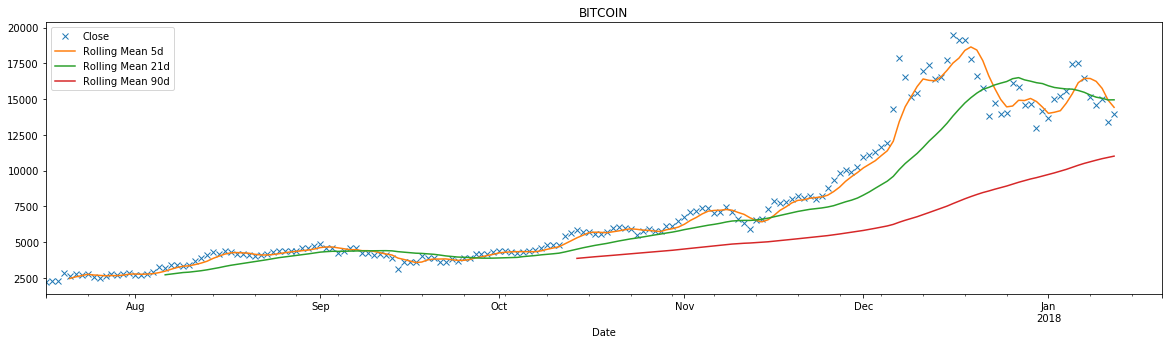

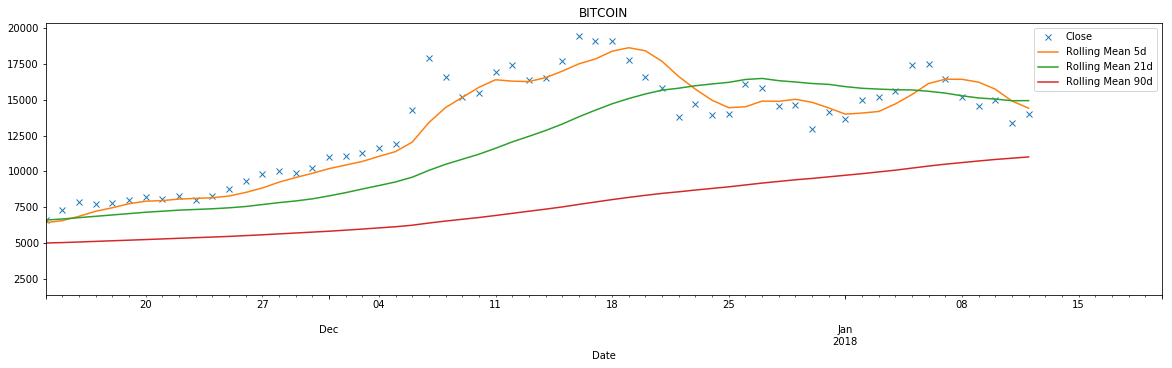

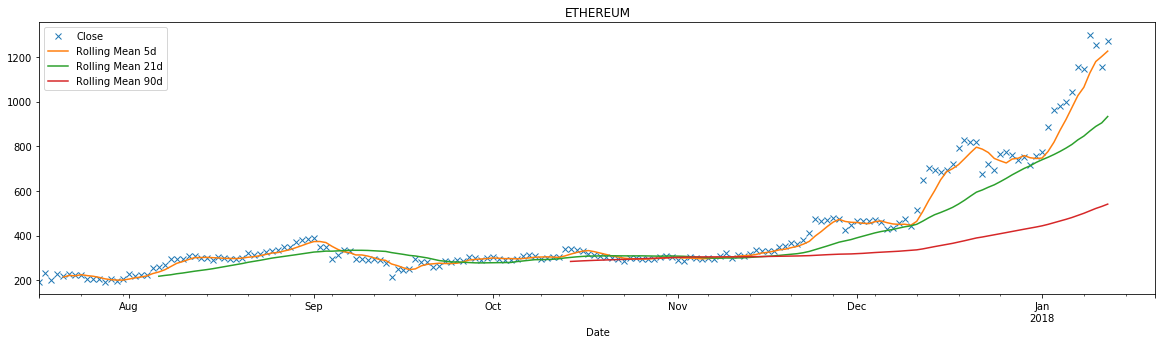

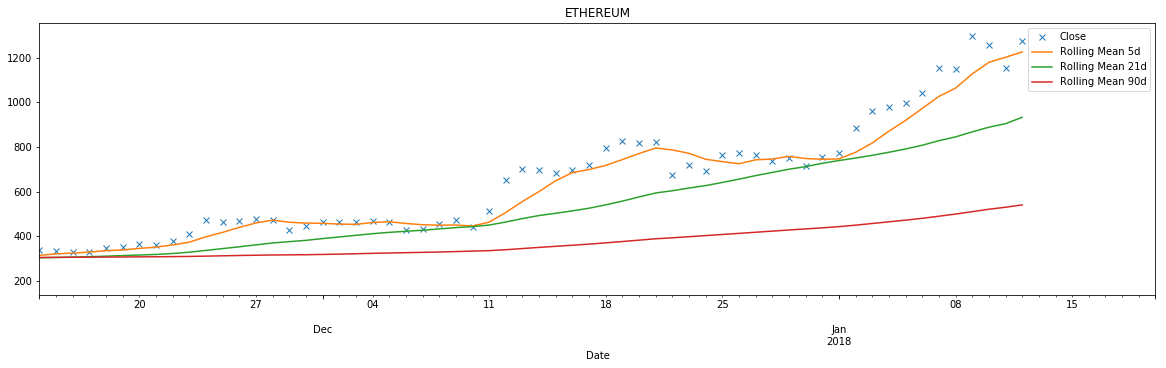

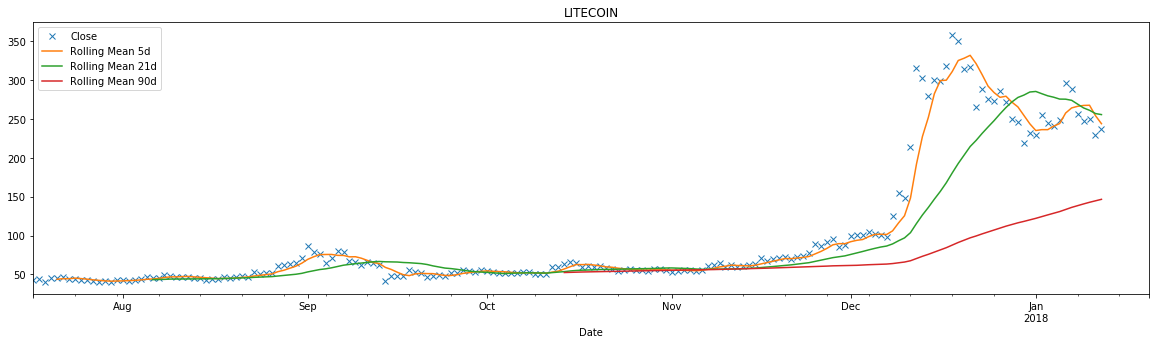

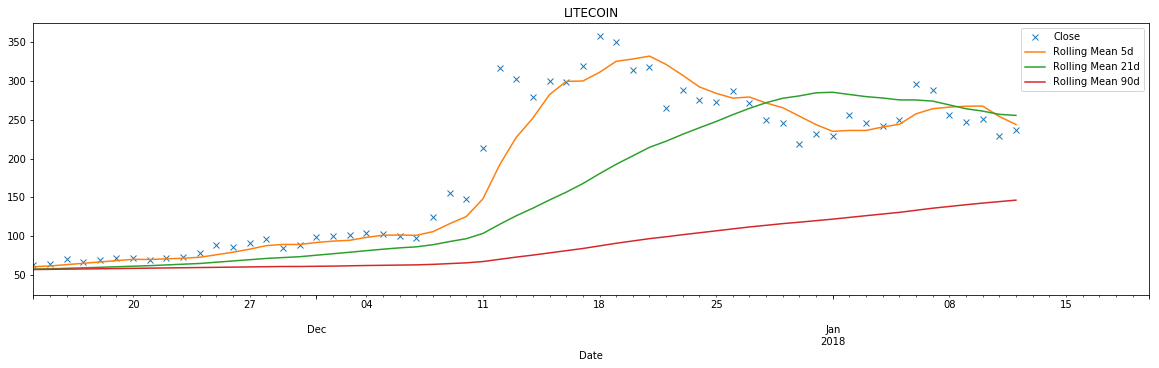

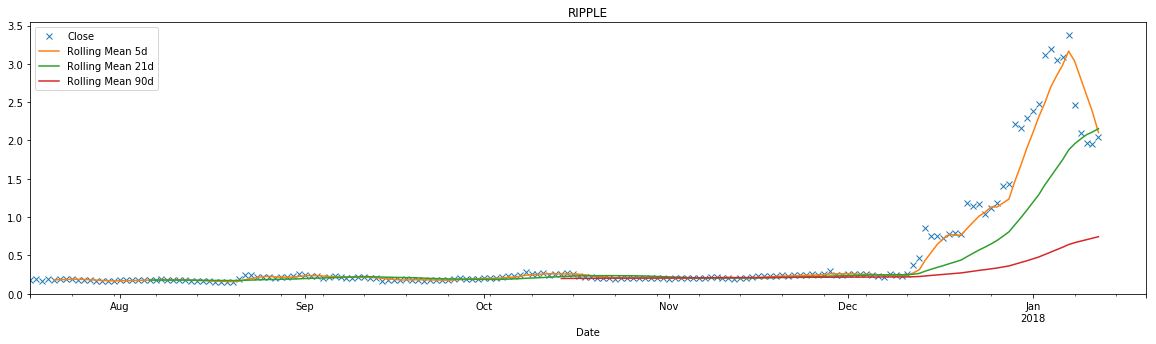

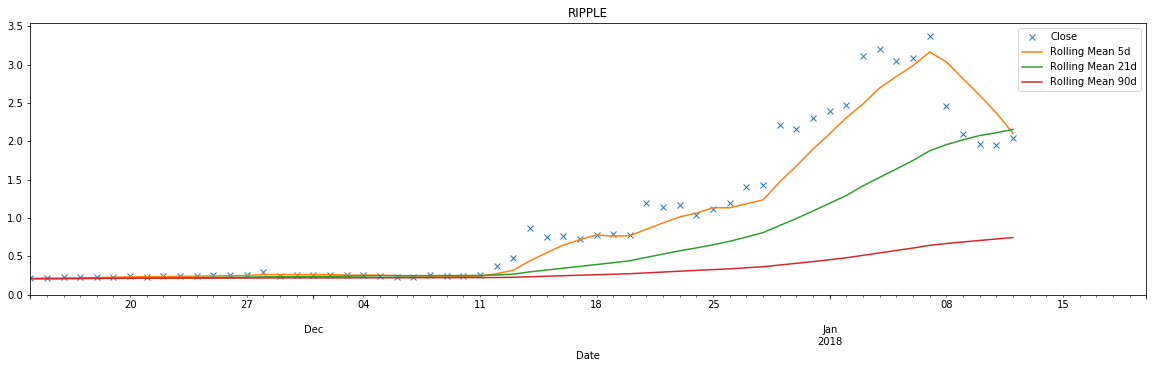

In [298]:
for coin in followed_coins:
    if flag_update_coin_history:
        update_coin_history(coin, history_start, history_end, result_dir_history)
    
    df_coin = get_coin_dataframe(result_dir_history + "/" + coin + ".csv")
    df_coin = calculate_moving_averages(df_coin)
    coin_long_plot = make_long_plot(df_coin, coin.upper(), start_long, end)
    coin_short_plot = make_short_plot(df_coin, coin.upper(), start_short, end)
    save_plot(coin_long_plot, coin + "_long_graph.png", result_dir_graphs)
    save_plot(coin_short_plot, coin + "_short_graph.png", result_dir_graphs)